In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import cv2
import json
import librosa
pd.options.mode.chained_assignment = None  # default='warn'
import os
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.models import load_model
from keras.callbacks import EarlyStopping

2024-04-12 11:14:17.835517: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 11:14:17.877502: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 11:14:18.555124: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
filtered_df = pd.read_csv('/home/mendu/Thesis/data/musiccaps/filtered_meta_df.csv', index_col=[0])

# Training the model

In [3]:
def add_gauss_noise(image, mean = 0, var = 10):
    '''function to add gaussian noise to an image'''
    sigma = var ** 0.5

    #creating a noise image with gaussian distribution
    gaussian = np.random.normal(mean, sigma, (image.shape[0], image.shape[1]))

    #creating a zeroes image
    noisy_image = np.zeros(image.shape, np.float32)

    #adding the noise to the original image
    noisy_image = image + gaussian

    #normalising the image
    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    #changing type
    noisy_image = noisy_image.astype(np.uint8)

    return noisy_image

In [4]:
len(filtered_df.fname.to_list())

2319

In [5]:
#loading the cropped .npy files in a tensor

#the folder path to where the mel-specs are stored
folder_path_mel = '/home/mendu/Thesis/data/musiccaps/mel-specs'

#The ordered list of all the filenames in the filtered_df
audio_names_list = filtered_df.fname.to_list()

data = []
i = 0

for filename in audio_names_list: #iterates over the filtered_df audio names
  filename_npy = str(filename) + '.wav.npy'
  file_path = os.path.join(folder_path_mel, filename_npy) #creates a folder path for the mel_specs 
  img = np.load(file_path)
  
  # Check to ensure the image has the minimum required dimensions
  if img.shape[0] >= 128 and img.shape[1] >= 431:
    img = img[:128, :431]
    data.append(add_gauss_noise(img))
  else:
    print(f"Error with file: {filename_npy}. Expected minimum shape of (128, 431) but got {img.shape}.")
    # Handle the error properly, either skip this image or pad/crop it accordingly

  # To ensure that the files are getting loaded in the correct order
  if i < 10 :
    print(filename)
  i = i+1

data = np.array(data)


[-0SdAVK79lg]-[30-40]
[-1LrH01Ei1w]-[30-40]
[-4NLarMj4xU]-[30-40]
[-5f6hjZf9Yw]-[30-40]
[-6QGvxvaTkI]-[280-290]
[-Dtir74TiUM]-[40-50]
[-FlvaZQOr2I]-[90-100]
[-JVWfFPBl84]-[330-340]
[-M-6VinyMiY]-[30-40]
[-O9mnfC61Ac]-[0-10]


In [6]:
#normalize data
data = data.astype('float32')/255.0

In [7]:
data.shape

(2319, 128, 431)

In [8]:
filtered_df

,fname,aspect_list
0,[-0SdAVK79lg]-[30-40],instrumental
1,[-1LrH01Ei1w]-[30-40],instrumental
2,[-4NLarMj4xU]-[30-40],pop
3,[-5f6hjZf9Yw]-[30-40],folk
4,[-6QGvxvaTkI]-[280-290],folk
...,...,...
2316,[zjsWFvUkh7M]-[30-40],rock
2317,[zrrM6Qg2Dwg]-[30-40],instrumental
2318,[zwfo7wnXdjs]-[30-40],folk
2319,[zx_vcwOsDO4]-[50-60],instrumental


In [9]:
# Reshape data to include the channel dimension
data = data.reshape((-1, 128, 431, 1))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, (filtered_df['aspect_list']), test_size=0.1, random_state=42)

# # Compute class weights manually for one-hot encoded labels
# class_totals = y_train.sum(axis=0)
# total_samples = y_train.shape[0]
# class_weights = total_samples / (len(class_totals) * class_totals)

# # Convert class weights to a dictionary for easier use
# class_weight_dict = dict(enumerate(class_weights))

In [10]:
temp_train = pd.DataFrame(list(zip(X_train, y_train.tolist())), columns = ['mel_spec', 'aspect_list'])

In [11]:
temp_train

,mel_spec,aspect_list
0,"[[[0.21176471], [0.2784314], [0.27450982], [0....",instrumental
1,"[[[0.49411765], [0.44705883], [0.36078432], [0...",country
2,"[[[0.3372549], [0.3529412], [0.3882353], [0.31...",pop
3,"[[[0.5058824], [0.47058824], [0.49411765], [0....",country
4,"[[[0.8156863], [0.81960785], [0.8156863], [0.7...",hip hop
...,...,...
2082,"[[[0.6509804], [0.7137255], [0.8235294], [0.8]...",instrumental
2083,"[[[0.43529412], [0.42745098], [0.4392157], [0....",classical
2084,"[[[0.57254905], [0.65882355], [0.6313726], [0....",pop
2085,"[[[0.09803922], [0.06666667], [0.4745098], [0....",folk


In [12]:
class_counts = temp_train['aspect_list'].value_counts()
max_samples = class_counts.max()

# Resample the data to balance the classes
resampled_data = []
for class_name, count in class_counts.items():
    # Calculate the number of samples to add to balance the class distribution
    num_samples_to_add = max_samples - count
    
    # Resample the minority class (with replacement)
    minority_class_samples = temp_train[temp_train['aspect_list'] == class_name].sample(n=num_samples_to_add, replace=True, random_state=42)
    
    # Append the resampled minority class samples to the resampled data list
    resampled_data.append(minority_class_samples)

# Concatenate the resampled data to create the balanced dataset
balanced_df = pd.concat([temp_train] + resampled_data, ignore_index=True)

# Verify the class distribution in the balanced dataset
print(balanced_df['aspect_list'].value_counts())

aspect_list
instrumental    643
country         643
pop             643
hip hop         643
electronic      643
metal           643
rock            643
classical       643
folk            643
r&b             643
jazz            643
Name: count, dtype: int64


In [13]:
X_train = np.stack(balanced_df['mel_spec'].tolist())

In [14]:
X_train.shape

(7073, 128, 431, 1)

In [15]:
y_train = pd.get_dummies(balanced_df['aspect_list'])

In [16]:
y_val = pd.get_dummies(y_val)

when there is no weights, the weight for each class is one. AFter applying weights the values are inversely propotionate to the count. Try to find something between 1 and the latter.

Oversample after splitting into val and train; not before

In [17]:
# Initialize ImageDataGenerator with necessary augmentations
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2
)

datagen.fit(X_train)

In [18]:
# Define num_classes based on the number of unique genres
num_classes = y_train.shape[1]
num_classes

11

In [19]:
#l2 regularisation
ltwo_reg = 0.001

# Initialize the model
model = Sequential()

#Convolution layers
model.add(Conv2D(32, (3, 3), kernel_regularizer=l2(ltwo_reg), input_shape=(128, 431, 1), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layers with L2 regularization
model.add(Dense(128, kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(ltwo_reg)))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

/home/mendu/miniconda3/envs/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-12 11:14:33.752855: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 429, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 429, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 126, 429, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 214, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 212, 64)    │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 212, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 61, 212, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 106, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 104, 128)   │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 104, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 28, 104, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93184)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,927,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,022,827 (45.86 MB)

 Trainable params: 12,022,123 (45.86 MB)

 Non-trainable params: 704 (2.75 KB)

Make the model deeper

In [20]:
X_train.shape

(7073, 128, 431, 1)

In [21]:
#Fitting the model and early stopping
early_stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    # class_weight=class_weight_dict,
    callbacks=[early_stopper]
)

Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 80s 353ms/step - accuracy: 0.3930 - loss: 2.7300 - val_accuracy: 0.3750 - val_loss: 3.6408
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 78s 351ms/step - accuracy: 0.8649 - loss: 1.5131 - val_accuracy: 0.3707 - val_loss: 3.6927
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 78s 351ms/step - accuracy: 0.9449 - loss: 1.2187 - val_accuracy: 0.3750 - val_loss: 6.4968
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 78s 351ms/step - accuracy: 0.9542 - loss: 1.1819 - val_accuracy: 0.1897 - val_loss: 5.2079
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 78s 351ms/step - accuracy: 0.9557 - loss: 1.2643 - val_accuracy: 0.3664 - val_loss: 5.5433
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 78s 351ms/step - accuracy: 0.9681 - loss: 1.3812 - val_accuracy: 0.1121 - val_loss: 8.6819
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


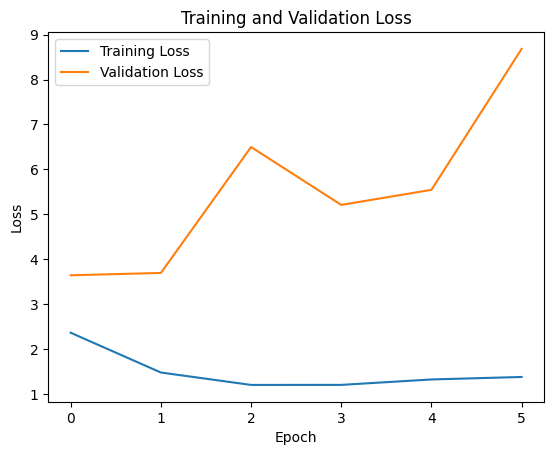

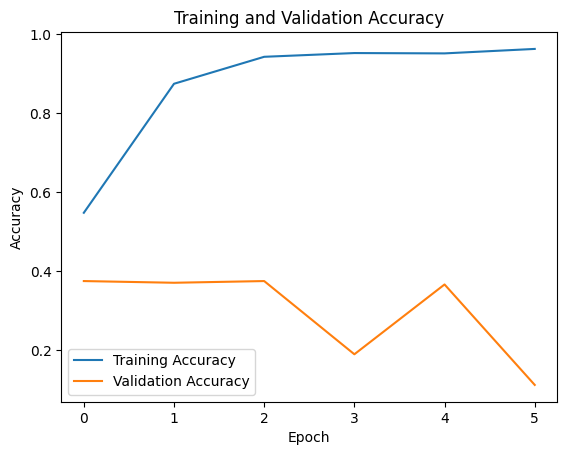

In [28]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
y_val

,classical,country,electronic,folk,hip hop,instrumental,jazz,metal,pop,r&b,rock
1125,False,False,False,False,False,False,False,False,True,False,False
548,False,True,False,False,False,False,False,False,False,False,False
100,False,False,False,False,False,False,False,False,True,False,False
838,False,False,False,False,False,True,False,False,False,False,False
251,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1075,False,False,False,False,False,True,False,False,False,False,False
1478,False,False,False,False,False,False,False,False,False,False,True
1715,False,False,False,False,False,False,False,False,False,False,True
1037,False,False,False,False,False,True,False,False,False,False,False


In [30]:
class_labels = ['classical', 'country', 'electronic', 'folk', 'hip hop', 
               'instrumental', 'jazz', 'metal', 'pop', 'r&b', 'rock']

predictions = model.predict(X_val)
predicted_labels = np.argmax(predictions, axis=1)  # Converting probabilities to class labels
ground_truth = np.argmax(y_val, axis=1)  # Converting one-hot encoded ground truth to class labels

# Reshape predicted_labels and ground_truth to be 1D arrays
predicted_labels = np.reshape(predicted_labels, (-1,))
ground_truth = np.reshape(ground_truth, (-1,))

predicted_labels = [class_labels[i] for i in predicted_labels]
ground_truth = [class_labels[i] for i in ground_truth]

# Creating a table with prediction and ground truth
comparison_table = pd.DataFrame({'Predicted': predicted_labels, 'Ground Truth': ground_truth})

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [31]:
comparison_table

,Predicted,Ground Truth
0,instrumental,pop
1,instrumental,country
2,instrumental,pop
3,instrumental,instrumental
4,instrumental,folk
...,...,...
227,instrumental,instrumental
228,instrumental,rock
229,instrumental,rock
230,instrumental,instrumental


In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

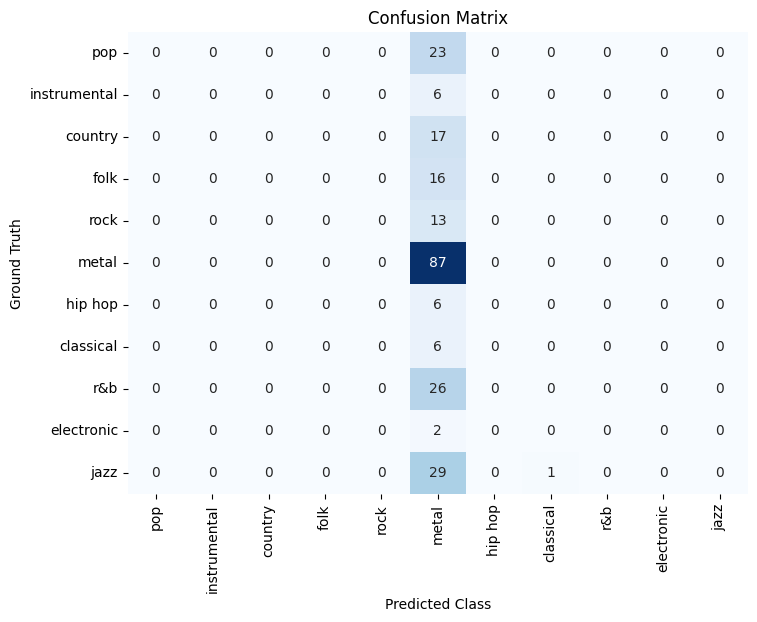

In [33]:

# Create confusion matrix
conf_matrix = confusion_matrix(comparison_table['Ground Truth'], comparison_table['Predicted'])

# Get unique class labels
unique_labels = pd.unique(comparison_table[['Ground Truth', 'Predicted']].values.ravel())

# Convert confusion matrix to DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=unique_labels, columns=unique_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()